In [ ]:
#https://www.kaggle.com/huanntran100/spotify-song-popularity-prediction/data

In [ ]:
!pip3 install kneed

In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy import stats
import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import plotnine
from plotnine import *
import itertools
import math
from prettytable import PrettyTable
from sklearn import preprocessing
from sklearn.cluster import KMeans, MeanShift
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, silhouette_score
from sklearn.metrics import plot_roc_curve, balanced_accuracy_score
from xgboost import XGBClassifier
import xgboost as xgb
from scipy.spatial import distance
from imblearn.over_sampling import SMOTE
from kneed import KneeLocator
import copy
import warnings
warnings.filterwarnings("ignore")
plotly.offline.init_notebook_mode(connected = True)
%matplotlib inline
sns.set(style = "ticks", context = "talk")

In [ ]:
data = pd.read_csv("/content/SpotifyFeatures.csv")
data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Opera,Giuseppe Verdi,"Stiffelio, Act III: Ei fugge! … Lina, pensai c...",7EsKYeHtTc4H4xWiTqSVZA,21,0.986,0.313,490867,0.23100,0.000431,C#,0.0964,-14.287,Major,0.0547,86.001,4/4,0.0886
1,Opera,Giacomo Puccini,Madama Butterfly / Act 1: ... E soffitto e pareti,7MfmRBvqaW0I6UTxXnad8p,18,0.972,0.360,176797,0.20100,0.028000,D#,0.1330,-19.794,Major,0.0581,131.798,4/4,0.3690
2,Opera,Giacomo Puccini,"Turandot / Act 2: Gloria, gloria, o vincitore",7pBo1GDhIysyUMFXiDVoON,10,0.935,0.168,266184,0.47000,0.020400,C,0.3630,-8.415,Major,0.0383,75.126,3/4,0.0696
3,Opera,Giuseppe Verdi,"Rigoletto, Act IV: Venti scudi hai tu detto?",02mvYZX5aKNzdqEo6jF20m,17,0.961,0.250,288573,0.00605,0.000000,D,0.1200,-33.440,Major,0.0480,76.493,4/4,0.0380
4,Opera,Giuseppe Verdi,"Don Carlo / Act 4: ""Ella giammai m'amò!""",03TW0jwGMGhUabAjOpB1T9,19,0.985,0.142,629760,0.05800,0.146000,D,0.0969,-23.625,Major,0.0493,172.935,4/4,0.0382


# Feature Engineering

### Combine Duplicated Songs Over the Years

Some songs appeared multiple times in the data frame, so here we will combine the songs that appeared multiple times by avaging their numeric features(effectively only the popularity column) over the all apperances 

In [ ]:
data_numeric_no_duplicated = data.groupby('track_id', as_index=False).mean()
print(data_numeric_no_duplicated.shape)
data_category_no_duplicated = data.select_dtypes(include=['object']).drop_duplicates(subset=['track_id'])
print(data_category_no_duplicated.shape)
data = data_numeric_no_duplicated.merge(data_category_no_duplicated,on='track_id')
data

(153685, 12)
(153685, 7)


,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,genre,artist_name,track_name,key,mode,time_signature
0,000CzNKC8PEt1yC3L8dqwV,5.0,0.249,0.518,130653.0,0.805,0.000000,0.3330,-6.248,0.0407,79.124,0.841,Movie,Henri Salvador,Coeur Brisé à Prendre - Remastered,F,Major,4/4
1,000DfZJww8KiixTKuk9usJ,30.0,0.366,0.631,357573.0,0.513,0.000004,0.1090,-6.376,0.0293,120.365,0.307,Reggae,Mike Love,Earthlings,D,Major,4/4
2,000EWWBkYaREzsBplYjUag,39.0,0.815,0.768,104924.0,0.137,0.922000,0.1130,-13.284,0.0747,76.430,0.560,Jazz,Don Philippe,Fewerdolr,C#,Minor,4/4
3,000xQL6tZNLJzIrtIgxqSl,70.0,0.131,0.748,188491.0,0.627,0.000000,0.0852,-6.029,0.0644,120.963,0.524,Dance,ZAYN,Still Got Time,G,Major,4/4
4,0017XiMkqbTfF2AUOzlhj6,27.0,0.792,0.536,127040.0,0.780,0.000000,0.7350,-9.449,0.9450,173.912,0.452,Comedy,Chad Daniels,Thanksgiving Chicken,F,Minor,3/4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153680,7zz3cHALU9cj7Io5qINt1R,21.0,0.833,0.353,273800.0,0.383,0.000131,0.1100,-8.232,0.0267,172.842,0.287,World,Hillsong Worship,Emmanuel,C#,Minor,3/4
153681,7zz7MbCb9G7KJc1NVl9bL0,38.0,0.400,0.851,251267.0,0.790,0.230000,0.1230,-4.641,0.0309,111.993,0.889,Jazz,Caravan Palace,Maniac,C,Minor,4/4
153682,7zzFNNxVD0h0ctAT08H0pa,40.0,0.973,0.538,266933.0,0.144,0.177000,0.3590,-17.711,0.0569,135.640,0.110,Jazz,Thelonious Monk Quartet,Crepescule With Nellie - Live At Carnegie Hall...,G#,Major,3/4
153683,7zzTeItz93lYI52hlcipm5,28.0,0.113,0.716,228493.0,0.806,0.000000,0.1510,-5.913,0.1350,136.069,0.544,Reggaeton,Magnate Y Valentino,Una En Un Millón,G,Minor,4/4


### Drop unneeded data

In [ ]:
# Get rid of tracks too long or too short because data containes podcast
data = data[np.abs(stats.zscore(data['duration_ms'])) <= 3]
# Drop duration becuase it is not an audio feature 
data = data.drop(['duration_ms'], axis=1)
# Drop key becuase it is not an relavent audio feature
data = data.drop(['key'], axis=1)
# Drop comedy category because they are not songs
data = data[~(data["genre"] == "Comedy")]
# Drop instrumentalness because most values are close to 0
data = data.drop(['instrumentalness'], axis=1)
# Drop time_signature because most values are "4/4"
data = data.drop(['time_signature'], axis=1)
# Drop energy because energy and loudness are highly corelated and loundness is more corelated to popularity
data = data.drop(['energy'], axis=1)
# Kepp an id df
data_id = data[["artist_name", "track_name", "track_id", "mode", "genre", "popularity"]]
# Drop other not needed features
data = data.drop(["artist_name", "track_name"], axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142683 entries, 0 to 153684
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   track_id      142683 non-null  object 
 1   popularity    142683 non-null  float64
 2   acousticness  142683 non-null  float64
 3   danceability  142683 non-null  float64
 4   liveness      142683 non-null  float64
 5   loudness      142683 non-null  float64
 6   speechiness   142683 non-null  float64
 7   tempo         142683 non-null  float64
 8   valence       142683 non-null  float64
 9   genre         142683 non-null  object 
 10  mode          142683 non-null  object 
dtypes: float64(8), object(3)
memory usage: 13.1+ MB


In [ ]:
data.describe()

,popularity,acousticness,danceability,liveness,loudness,speechiness,tempo,valence
count,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000
mean,39.681628,0.382980,0.540679,0.194257,-10.163494,0.086237,117.551059,0.441665
std,16.901008,0.363308,0.196970,0.168404,6.609099,0.095386,31.022450,0.270136
min,0.000000,0.000001,0.056900,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,29.000000,0.041850,0.404000,0.096000,-12.725500,0.036500,92.510000,0.206000
50%,41.000000,0.247000,0.561000,0.123000,-7.972000,0.047600,115.475000,0.425000
75%,51.000000,0.753000,0.693000,0.236000,-5.590000,0.087100,139.509000,0.661000
max,100.000000,0.996000,0.987000,1.000000,1.585000,0.965000,239.848000,1.000000


### Normalize Numeric features

Use min max because all the numberical features has an upper and lower bound

In [ ]:
sc = MinMaxScaler()
# get numeric data
num_data = data.select_dtypes(exclude=['object'])
num_data = num_data.drop(['popularity'], axis=1)
# update the cols with their normalized values
data[num_data.columns] = sc.fit_transform(num_data)
data

,track_id,popularity,acousticness,danceability,liveness,loudness,speechiness,tempo,valence,genre,mode
0,000CzNKC8PEt1yC3L8dqwV,5.0,0.249999,0.495753,0.326487,0.855057,0.019622,0.232707,0.841,Movie,Major
1,000DfZJww8KiixTKuk9usJ,30.0,0.367469,0.617245,0.100300,0.852689,0.007531,0.429591,0.307,Reggae,Major
2,000EWWBkYaREzsBplYjUag,39.0,0.818273,0.764541,0.104339,0.724862,0.055685,0.219846,0.560,Jazz,Minor
3,000xQL6tZNLJzIrtIgxqSl,70.0,0.131525,0.743038,0.076268,0.859110,0.044760,0.432446,0.524,Dance,Major
5,001KkOBeRiQ1J7IEJYHODW,31.0,0.069979,0.238792,0.088587,0.796473,0.007425,0.478582,0.110,World,Major
...,...,...,...,...,...,...,...,...,...,...,...
153680,7zz3cHALU9cj7Io5qINt1R,21.0,0.836345,0.318353,0.101310,0.818345,0.004773,0.680115,0.287,World,Minor
153681,7zz7MbCb9G7KJc1NVl9bL0,38.0,0.401606,0.853779,0.114437,0.884793,0.009228,0.389623,0.889,Jazz,Minor
153682,7zzFNNxVD0h0ctAT08H0pa,40.0,0.976908,0.517256,0.352741,0.642944,0.036805,0.502513,0.110,Jazz,Major
153683,7zzTeItz93lYI52hlcipm5,28.0,0.113453,0.708633,0.142710,0.861256,0.119644,0.504562,0.544,Reggaeton,Minor


### Encode categorical features

In [ ]:
# Using one-hot encoding because these categorical features are nominal
data = data.drop(["genre", "track_id"], axis=1)
data = pd.get_dummies(data)
data

,popularity,acousticness,danceability,liveness,loudness,speechiness,tempo,valence,mode_Major,mode_Minor
0,5.0,0.249999,0.495753,0.326487,0.855057,0.019622,0.232707,0.841,1,0
1,30.0,0.367469,0.617245,0.100300,0.852689,0.007531,0.429591,0.307,1,0
2,39.0,0.818273,0.764541,0.104339,0.724862,0.055685,0.219846,0.560,0,1
3,70.0,0.131525,0.743038,0.076268,0.859110,0.044760,0.432446,0.524,1,0
5,31.0,0.069979,0.238792,0.088587,0.796473,0.007425,0.478582,0.110,1,0
...,...,...,...,...,...,...,...,...,...,...
153680,21.0,0.836345,0.318353,0.101310,0.818345,0.004773,0.680115,0.287,0,1
153681,38.0,0.401606,0.853779,0.114437,0.884793,0.009228,0.389623,0.889,0,1
153682,40.0,0.976908,0.517256,0.352741,0.642944,0.036805,0.502513,0.110,1,0
153683,28.0,0.113453,0.708633,0.142710,0.861256,0.119644,0.504562,0.544,0,1


In [ ]:
data.describe()

,popularity,acousticness,danceability,liveness,loudness,speechiness,tempo,valence,mode_Major,mode_Minor
count,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000
mean,39.681628,0.384517,0.520136,0.186389,0.782604,0.067923,0.416157,0.441665,0.648949,0.351051
std,16.901008,0.364767,0.211773,0.170048,0.122296,0.101174,0.148100,0.270136,0.477301,0.477301
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,0.042017,0.373186,0.087173,0.735197,0.015168,0.296612,0.206000,0.000000,0.000000
50%,41.000000,0.247991,0.541985,0.114437,0.823156,0.026941,0.406246,0.425000,1.000000,0.000000
75%,51.000000,0.756024,0.683905,0.228540,0.867233,0.068838,0.520984,0.661000,1.000000,1.000000
max,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# K-Means

### Clustering

Only use numeric features(except popularity) because the clusters may be labeled by categorical features

In [ ]:
# Try k = 2 to 20, this takes about 3 mins to run 
X = data._get_numeric_data().drop(["popularity"], axis=1)
ss_dist = []
K = range(2, 20)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', random_state=123)
    km = km.fit(X)
    ss_dist.append(km.inertia_)

5


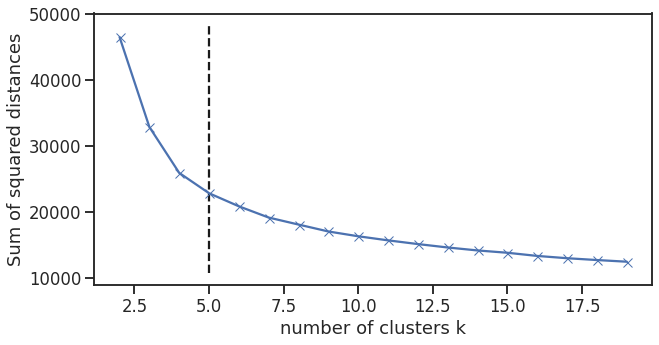

In [ ]:
kn = KneeLocator(K, ss_dist, curve='convex', direction='decreasing')
print(kn.knee)

plt.figure(figsize=(10, 5))
plt.xlabel('number of clusters k')
plt.ylabel('Sum of squared distances')
plt.plot(K, ss_dist, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

In [ ]:
# Final model
k = 5
X = data._get_numeric_data().drop(["popularity"], axis=1)
km = KMeans(n_clusters=k, init='k-means++', random_state=123).fit(X)
X

,acousticness,danceability,liveness,loudness,speechiness,tempo,valence,mode_Major,mode_Minor
0,0.249999,0.495753,0.326487,0.855057,0.019622,0.232707,0.841,1,0
1,0.367469,0.617245,0.100300,0.852689,0.007531,0.429591,0.307,1,0
2,0.818273,0.764541,0.104339,0.724862,0.055685,0.219846,0.560,0,1
3,0.131525,0.743038,0.076268,0.859110,0.044760,0.432446,0.524,1,0
5,0.069979,0.238792,0.088587,0.796473,0.007425,0.478582,0.110,1,0
...,...,...,...,...,...,...,...,...,...
153680,0.836345,0.318353,0.101310,0.818345,0.004773,0.680115,0.287,0,1
153681,0.401606,0.853779,0.114437,0.884793,0.009228,0.389623,0.889,0,1
153682,0.976908,0.517256,0.352741,0.642944,0.036805,0.502513,0.110,1,0
153683,0.113453,0.708633,0.142710,0.861256,0.119644,0.504562,0.544,0,1


### Cluster Results

In [ ]:
data_clustered = X.copy()
data_clustered["cluster"] = km.labels_
data_clustered

,acousticness,danceability,liveness,loudness,speechiness,tempo,valence,mode_Major,mode_Minor,cluster
0,0.249999,0.495753,0.326487,0.855057,0.019622,0.232707,0.841,1,0,4
1,0.367469,0.617245,0.100300,0.852689,0.007531,0.429591,0.307,1,0,0
2,0.818273,0.764541,0.104339,0.724862,0.055685,0.219846,0.560,0,1,1
3,0.131525,0.743038,0.076268,0.859110,0.044760,0.432446,0.524,1,0,4
5,0.069979,0.238792,0.088587,0.796473,0.007425,0.478582,0.110,1,0,0
...,...,...,...,...,...,...,...,...,...,...
153680,0.836345,0.318353,0.101310,0.818345,0.004773,0.680115,0.287,0,1,1
153681,0.401606,0.853779,0.114437,0.884793,0.009228,0.389623,0.889,0,1,3
153682,0.976908,0.517256,0.352741,0.642944,0.036805,0.502513,0.110,1,0,2
153683,0.113453,0.708633,0.142710,0.861256,0.119644,0.504562,0.544,0,1,3


In [ ]:
data_clustered.groupby('cluster').size().reset_index(name='Num of songs')

,cluster,Num of songs
0,0,30037
1,1,14782
2,2,30912
3,3,35307
4,4,31645


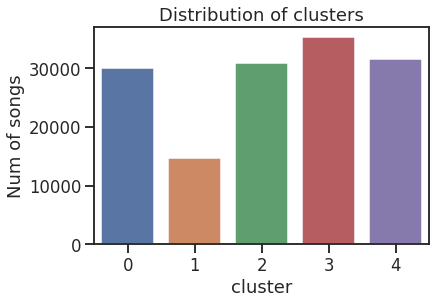

In [ ]:
cluster_size = data_clustered.groupby('cluster').size().reset_index(name='Num of songs')
sns.barplot(data=cluster_size, x='cluster', y='Num of songs',)
plt.title('Distribution of clusters')
plt.show()

###Songs From Each Cluster

In [ ]:
# for cluster in range(k):
#   print("Cluster #", cluster)
#   print(data_id[data_clustered['cluster'] == cluster].sort_values(by=['popularity'], ascending=False).head(10))
#   print()

In [ ]:
cluster = 0
#data_id[data_clustered['cluster'] == cluster].sort_values(by=['popularity'], ascending=False).head(10)
data_id[data_clustered['cluster'] == cluster]

,artist_name,track_name,track_id,mode,genre,popularity
1,Mike Love,Earthlings,000DfZJww8KiixTKuk9usJ,Major,Reggae,30.0
5,C3 Music,The Father's Love - Live,001KkOBeRiQ1J7IEJYHODW,Major,World,31.0
8,Justin Quiles,No Quieren Que Gane,001bQcMKt86oNbnWne4EAB,Major,Reggaeton,41.0
10,Young Tribe,Kingdom,001gDjxhKGDSx4sMMAgS9R,Major,Blues,57.2
14,Young Dolph,Still Smell Like It,002QT7AS6h1LAF5dla8D92,Major,Rap,50.0
...,...,...,...,...,...,...
153657,Sigrid,Mine Right Now,7zvwxSE35TwHoXiolyjRDX,Major,Dance,0.0
153672,boy pablo,Sick Feeling,7zxLkZbUxITHabPzGN8Xgc,Major,Pop,66.0
153673,NAV,Some Way,7zxRMhXxJMQCeDDg0rKAVo,Major,Pop,75.0
153679,Montgomery Gentry,If You Ever Stop Loving Me,7zywdG4ysfC5XNBzjQAo2o,Major,Country,43.0


In [ ]:
cluster = 1
#data_id[data_clustered['cluster'] == cluster].sort_values(by=['popularity'], ascending=False).head(10)
data_id[data_clustered['cluster'] == cluster]

,artist_name,track_name,track_id,mode,genre,popularity
2,Don Philippe,Fewerdolr,000EWWBkYaREzsBplYjUag,Minor,Jazz,39.0
6,Ramin Djawadi,"Await The King's Justice - From The ""Game Of T...",001VMKfkHZrlyj7JlQbQFL,Minor,Soundtrack,41.0
12,Lorne Balfe,Welcome to Boston,002HVvfZx6AKPzJEeimuu5,Minor,Soundtrack,32.0
50,Lea Salonga,When The Winter's Gone,009WMlG6QHmA5tMiNQs4VV,Minor,Movie,15.0
51,Thomas Newman,And That Right Soon,009jzOyt9tXCqaUzeFIT03,Minor,Soundtrack,29.0
...,...,...,...,...,...,...
153644,Stevie Ray Vaughan,Tin Pan Alley (AKA Roughest Place in Town),7zto61V8ySp03Qi6X1LU2X,Minor,Rock,55.0
153653,Johann Sebastian Bach,"Das Wohltemperierte Klavier: Book 2, BWV 870-8...",7zv2BCCUu8bwd9fo9BA8IK,Minor,Classical,43.0
153654,Glad,You Put This Love in My Heart,7zvJ5hM42ZzYILWH1kS7h6,Minor,A Capella,7.0
153674,Heitor Villa-Lobos,"Bachianas brasileiras No.5, W. 389: 1. Aria (C...",7zxjg30u7dNEpvoW76YP8n,Minor,Classical,39.0


### Visualize Results in Lower Dimension vs. Categorical Labels

Dimesion reduce the data set to visualize the cluster and see if any cluster matches with a categorical label.

##### PCA

In [ ]:
pca = PCA()
pca_results = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
pca.explained_variance_ratio_.cumsum()

[5.83804355e-01 2.29641272e-01 7.73456154e-02 3.78138646e-02
 2.89622463e-02 2.36349453e-02 1.14239138e-02 7.37378851e-03
 3.32229965e-32]


array([0.58380435, 0.81344563, 0.89079124, 0.92860511, 0.95756735,
       0.9812023 , 0.99262621, 1.        , 1.        ])

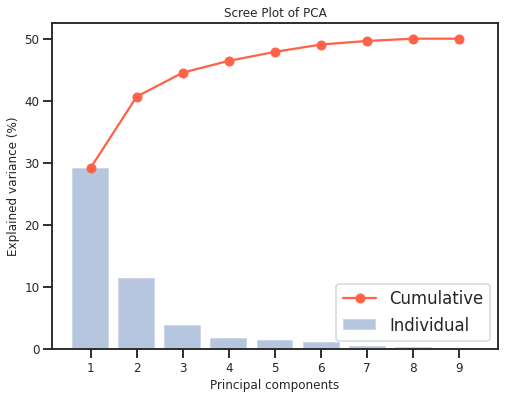

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, 
        label='Individual', axes=ax, alpha=0.4)
plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_.cumsum(), 
         label='Cumulative', color='tomato', axes=ax, marker='o')

ax.set_xticks(range(len(pca.explained_variance_ratio_)))
ax.set_xticklabels(range(1,len(pca.explained_variance_ratio_)+1), fontsize=12)
ax.set_yticklabels(range(0,90,10), fontsize=12)

plt.title('Scree Plot of PCA', fontsize=12)
plt.ylabel('Explained variance (%)', fontsize=12)
plt.xlabel('Principal components', fontsize=12)
plt.legend()
plt.show()

In [ ]:
df_pca = pd.DataFrame(pca_results, index=X.index)
df_pca['cluster'] = km.labels_
df_pca = pd.concat([df_pca, data_id],axis=1)
df_pca

,0,1,2,3,4,5,6,7,8,cluster,artist_name,track_name,track_id,mode,genre,popularity
0,-0.483609,-0.302825,0.213048,0.170066,-0.020389,-0.289018,-0.017956,-0.036500,-7.939604e-16,4,Henri Salvador,Coeur Brisé à Prendre - Remastered,000CzNKC8PEt1yC3L8dqwV,Major,Movie,5.0
1,-0.493076,-0.029357,-0.076571,-0.134806,-0.067295,0.092517,-0.081956,-0.051509,-2.264597e-15,0,Mike Love,Earthlings,000DfZJww8KiixTKuk9usJ,Major,Reggae,30.0
2,0.905063,0.300137,0.430593,-0.112483,-0.208066,0.004283,-0.046951,-0.010332,3.601485e-17,1,Don Philippe,Fewerdolr,000EWWBkYaREzsBplYjUag,Minor,Jazz,39.0
3,-0.472982,-0.355826,0.004389,-0.162879,-0.062007,0.053189,-0.046149,0.006888,-4.044264e-16,4,ZAYN,Still Got Time,000xQL6tZNLJzIrtIgxqSl,Major,Dance,70.0
5,-0.495741,-0.042128,-0.523528,-0.090894,0.132710,-0.066242,-0.001242,-0.000088,-4.583179e-16,0,C3 Music,The Father's Love - Live,001KkOBeRiQ1J7IEJYHODW,Major,World,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153680,0.884143,0.522860,0.048893,0.001657,0.283064,0.183364,-0.069440,-0.131068,-8.550299e-17,1,Hillsong Worship,Emmanuel,7zz3cHALU9cj7Io5qINt1R,Minor,World,21.0
153681,0.934778,-0.253200,0.465513,-0.073776,-0.028748,-0.008104,-0.104839,-0.042522,-4.964250e-17,3,Caravan Palace,Maniac,7zz7MbCb9G7KJc1NVl9bL0,Minor,Jazz,38.0
153682,-0.532339,0.602392,0.065728,0.129849,-0.105630,0.277258,-0.079256,0.035493,-2.873562e-17,2,Thelonious Monk Quartet,Crepescule With Nellie - Live At Carnegie Hall...,7zzFNNxVD0h0ctAT08H0pa,Major,Jazz,40.0
153683,0.938928,-0.295177,-0.005479,-0.060189,0.007217,0.088210,0.011214,0.002697,-3.809886e-17,3,Magnate Y Valentino,Una En Un Millón,7zzTeItz93lYI52hlcipm5,Minor,Reggaeton,28.0


##### PCA vs. Categorical Labels in 2D

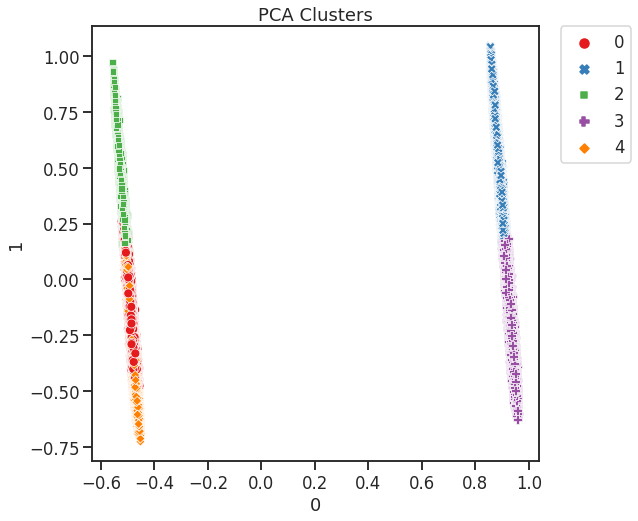

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df_pca, x=0, y=1, hue='cluster', style='cluster', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('PCA Clusters')
plt.show()

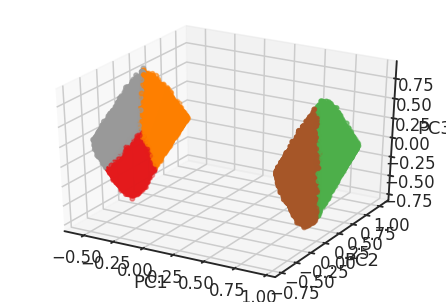

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df_pca[0], df_pca[1], df_pca[2],
           c=df_pca['cluster'], cmap='Set1')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

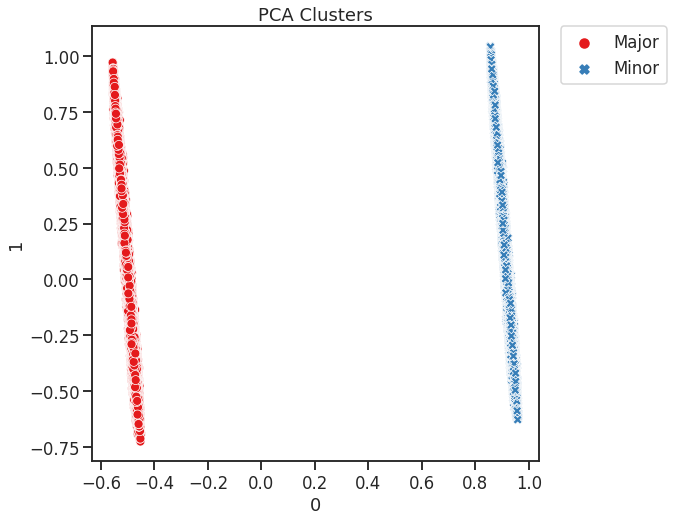

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df_pca, x=0, y=1, hue='mode', style='mode', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('PCA Clusters')
plt.show()

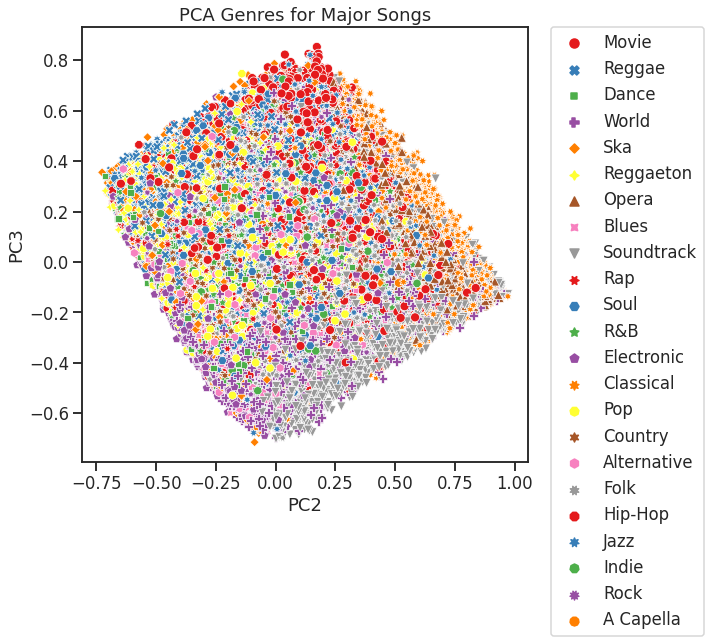

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df_pca[df_pca["mode"]=="Major"], x=1, y=2, hue='genre', style='genre', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('PCA Genres for Major Songs')
ax.set_xlabel('PC2')
ax.set_ylabel('PC3')
plt.show()

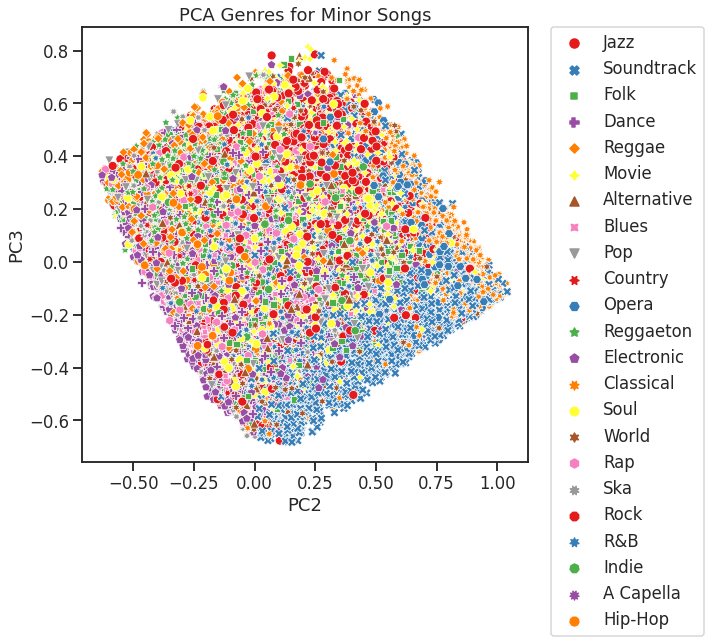

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df_pca[df_pca["mode"]=="Minor"], x=1, y=2, hue='genre', style='genre', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('PCA Genres for Minor Songs')
ax.set_xlabel('PC2')
ax.set_ylabel('PC3')
plt.show()

### Visualize Results in Full Dimension Histograms vs. Categorical Labels

Plot cluster profiling histograms for each categorical feature vs clsuters so that:  

1. We can see if there is high representations of specific categories in a cluster (ex: cluster 1 could containe mostly hip hop songs, so cluster 1 should be labeled as hip hop) 

2. We can see if we can create new labels for clusters(ex: cluster 3 may have significatly large amount of rap songs and songs in minor mode, we can label cluster 3 as sad rap songs).

In [ ]:
data_cate = data_id.drop(["artist_name", "track_name", "track_id", "popularity"], axis = 1)
data_cate["cluster"] = data_clustered['cluster']
data_cate

,mode,genre,cluster
0,Major,Movie,4
1,Major,Reggae,0
2,Minor,Jazz,1
3,Major,Dance,4
5,Major,World,0
...,...,...,...
153680,Minor,World,1
153681,Minor,Jazz,3
153682,Major,Jazz,2
153683,Minor,Reggaeton,3


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e7caf4bd0>],
      dtype=object)

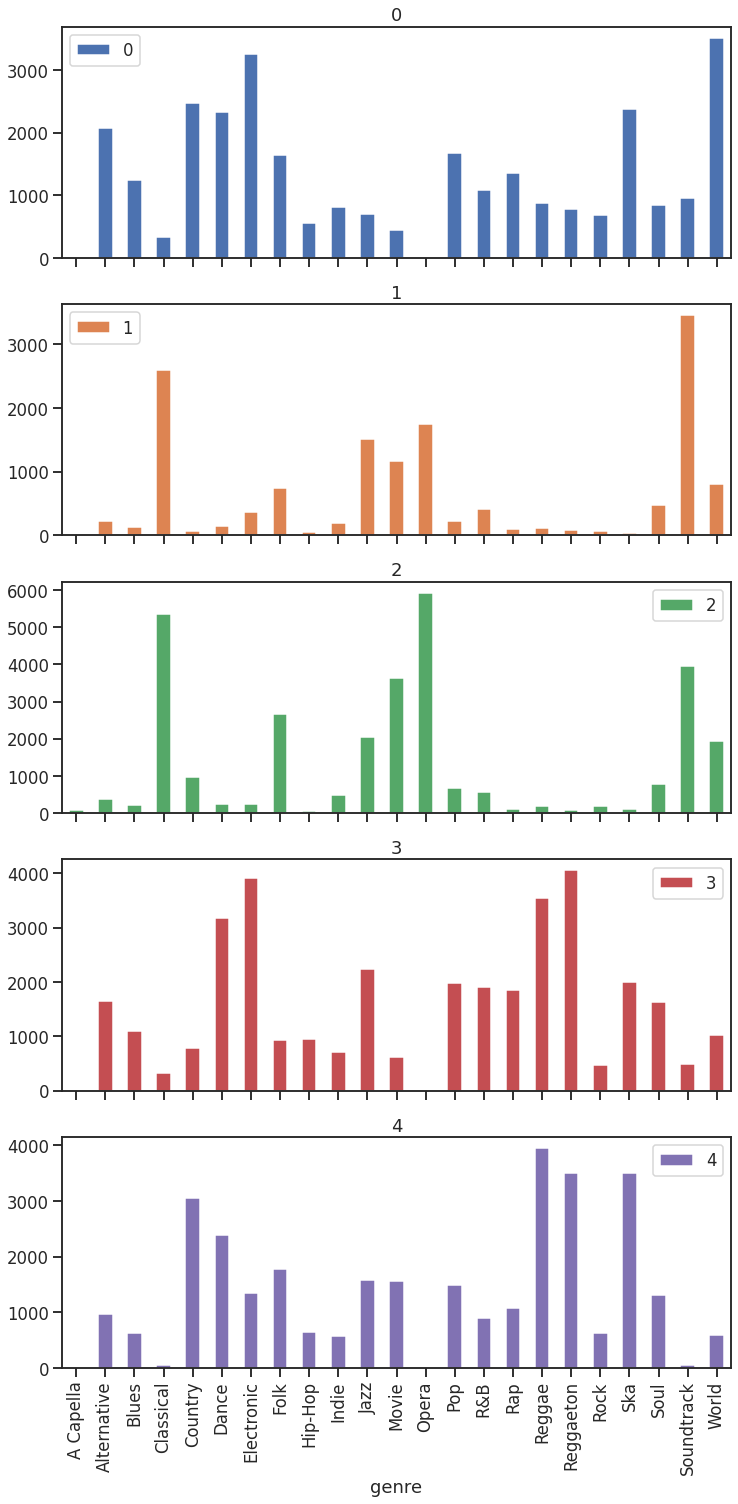

In [ ]:
data_cate.groupby(["genre", "cluster"]).size().unstack().fillna(0).plot(kind='bar', subplots=True, layout=(8,1), figsize=(12, 40))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e6fd41e90>,
      dtype=object)

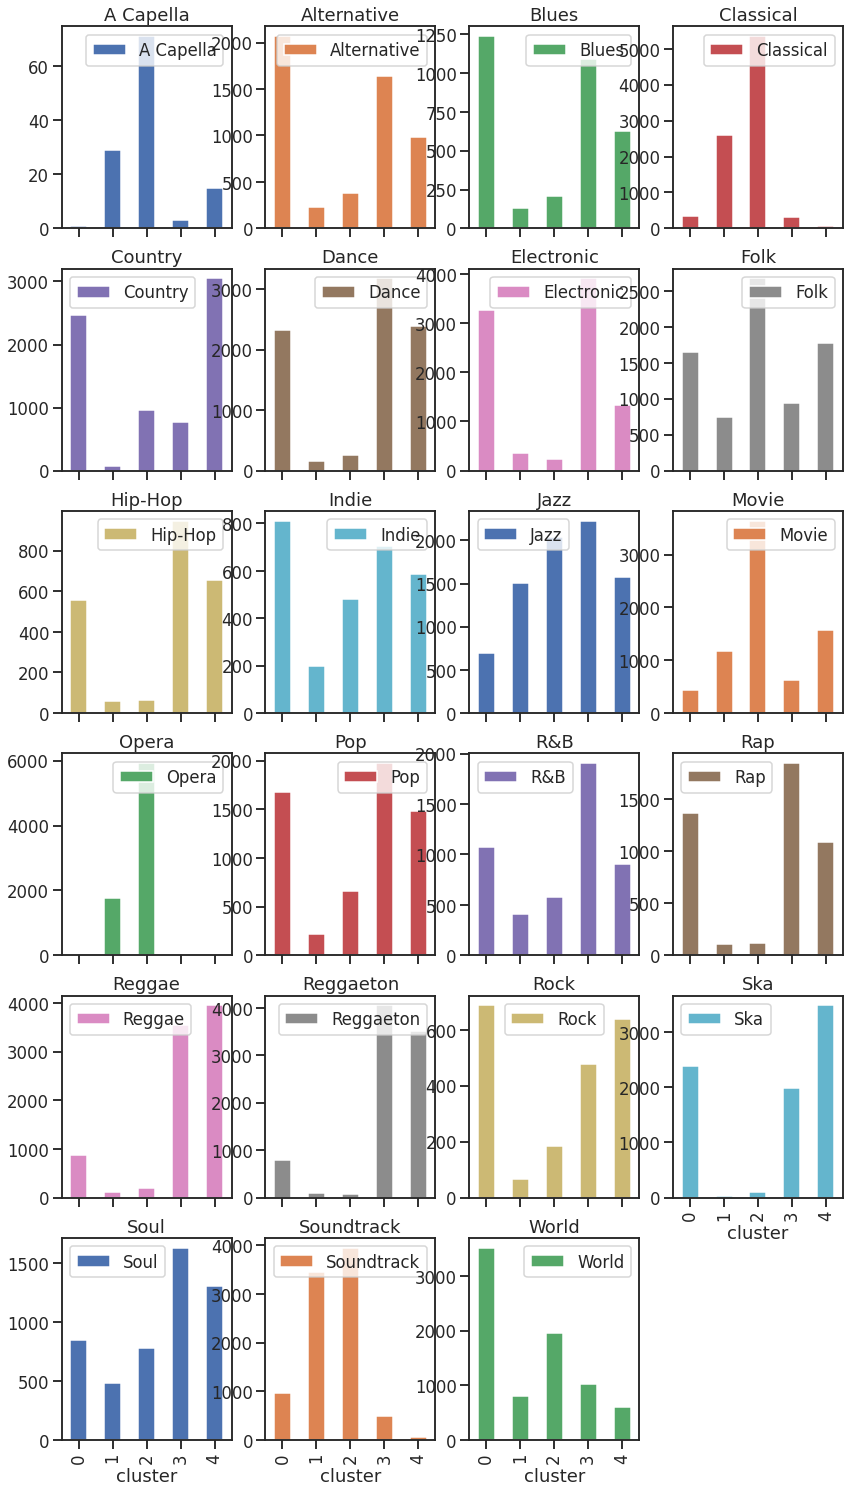

In [ ]:
data_cate.groupby(["cluster", "genre"]).size().unstack().fillna(0).plot(kind='bar', subplots=True, layout=(6,4), figsize=(14, 26))

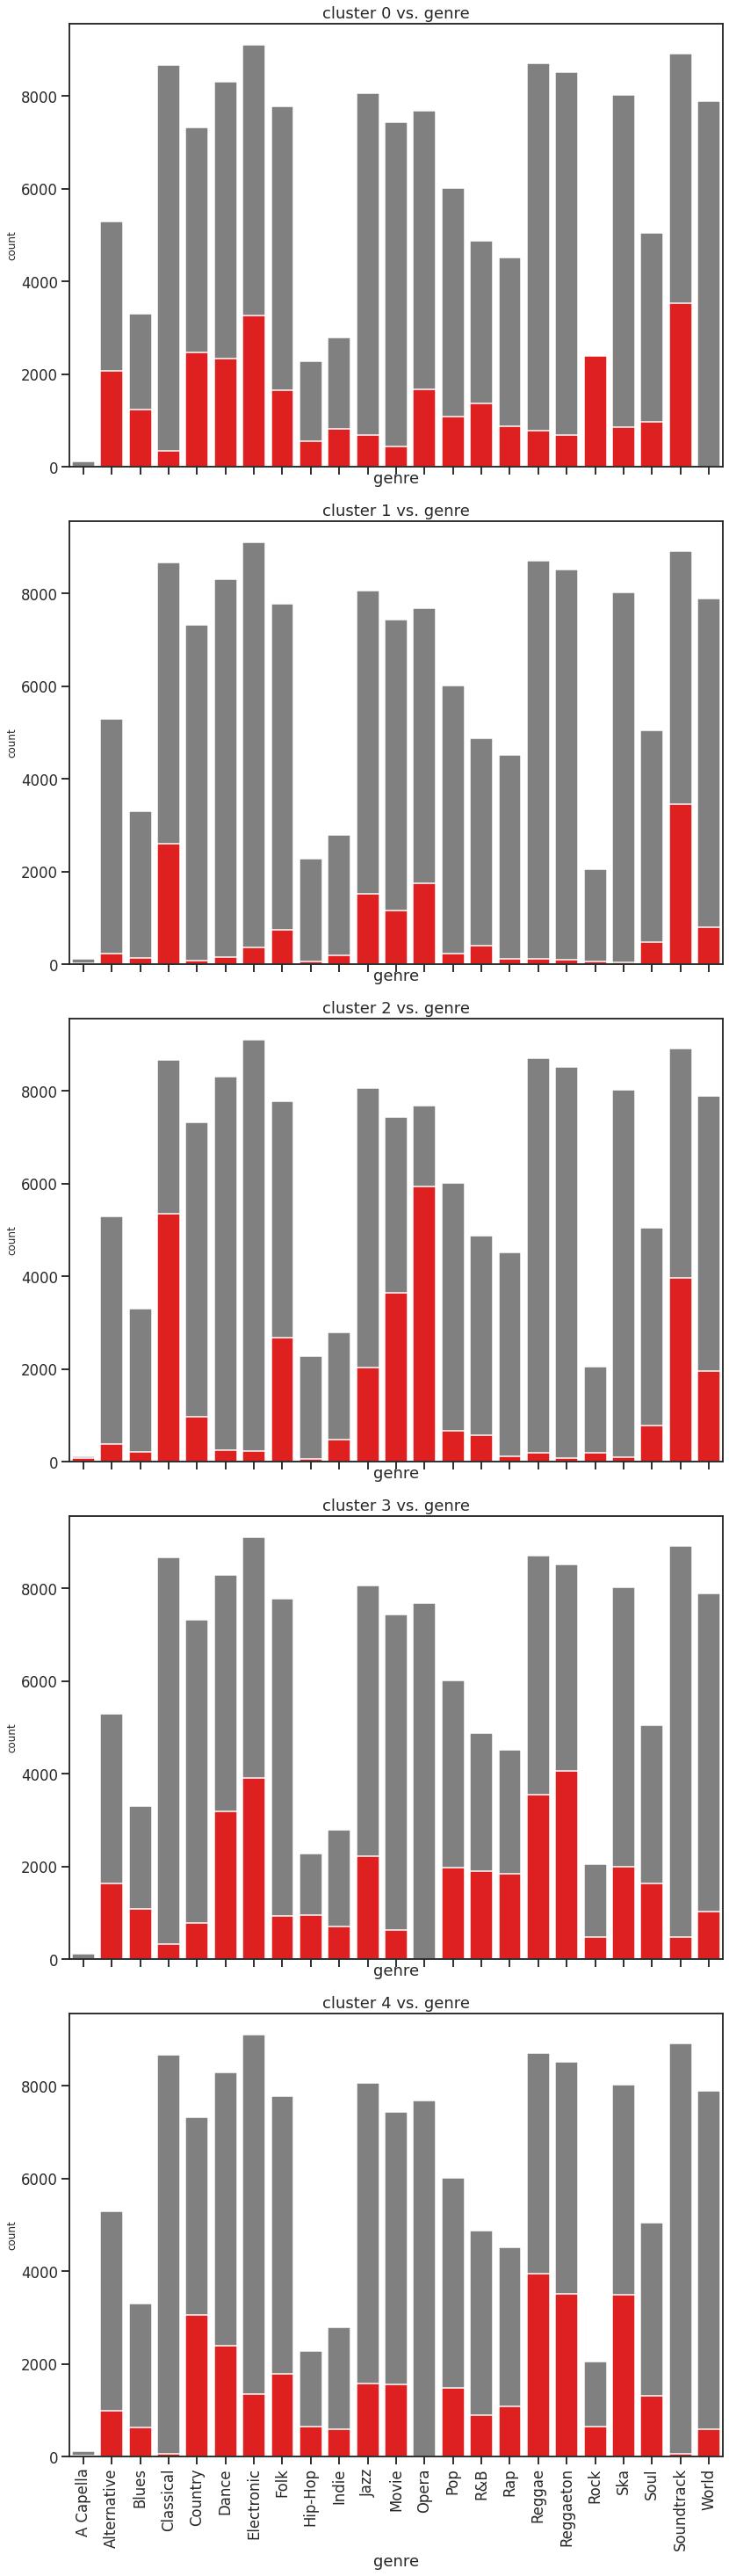

In [ ]:
# create subplots
num_features = 1
f, axes = plt.subplots(k, num_features, 
                       figsize=(12, 40), sharex='col')

# initialise 1st row. Representing cluster
row = 0
for cluster in np.sort(data_cate['cluster'].unique()):
#     filter cluster dataframe and reset column to 0 for 1st plot for the cluster
    df_cluster = data_cate[data_cate['cluster'] == cluster]
    feature = "genre"
#         create binned count for all recent df and clustered df
    rec_grp = data_cate.groupby(feature).size().reset_index(name='count')
    cluster_grp = df_cluster.groupby(feature).size().reset_index(name='count')
    
#         plot overall distribution and cluster distribution on the ax
    sns.barplot(data=rec_grp, x=feature, y='count', 
                color='grey', ax=axes[row])
    sns.barplot(data=cluster_grp, x=feature, y='count', 
                color='red', ax=axes[row])
    
#         configure ax
    # axes[row, col].set_xlabel('')
    #axes[row].set_xticklabels(range(1,10), fontsize=12)
    axes[row].set_ylabel('count', fontsize=12)
    axes[row].set_title(f"cluster {cluster} vs. genre")
    row += 1
plt.tight_layout()
plt.xticks(rotation = 90)
plt.show()

In [ ]:
# # set binning intervals 
# bins = np.linspace(0,1,15)

# # create subplots
# num_features = 4
# f, axes = plt.subplots(k, num_features, 
#                        figsize=(20, 40), sharex='col')

# # initialise 1st row. Representing cluster
# row = 0
# for cluster in np.sort(data_cate['cluster'].unique()):
# #     filter cluster dataframe and reset column to 0 for 1st plot for the cluster
#     df_cluster = data_cate[data_cate['cluster'] == cluster]
#     col = 0
    
#     for feature in data_cate.columns:
# #         create binned count for all recent df and clustered df
#         rec_grp = data_cate.groupby(feature).size().reset_index(name='count')
#         cluster_grp = df_cluster.groupby(feature).size().reset_index(name='count')
        
# #         plot overall distribution and cluster distribution on the ax
#         sns.barplot(data=rec_grp, x=feature, y='count', 
#                     color='grey', ax=axes[row, col])
#         sns.barplot(data=cluster_grp, x=feature, y='count', 
#                     color='red', ax=axes[row, col])
        
# #         configure ax
#         # axes[row, col].set_xlabel('')
#         axes[row, col].set_xticklabels(range(1,10), fontsize=12)
#         if col > 0:
#             axes[row, col].set_ylabel('')
#         else:
#             axes[row, col].set_ylabel('count', fontsize=12)
#         if row == 0:
#             axes[row, col].set_title(feature, fontsize=14)        
#         col += 1
#     row += 1
    
# f.suptitle('Numeric Features vs. Clusters')
    
# plt.show()

### Visualize Results in Full Dimension Histograms vs. Numerical Features

Plot cluster profiling histograms for each numerical feature vs clsuters, and see if we can create new labels for clusters. 

Ex: if cluster 3 have significatly large amount of dancibility and energy songs, we can label cluster 3 as dancing songs

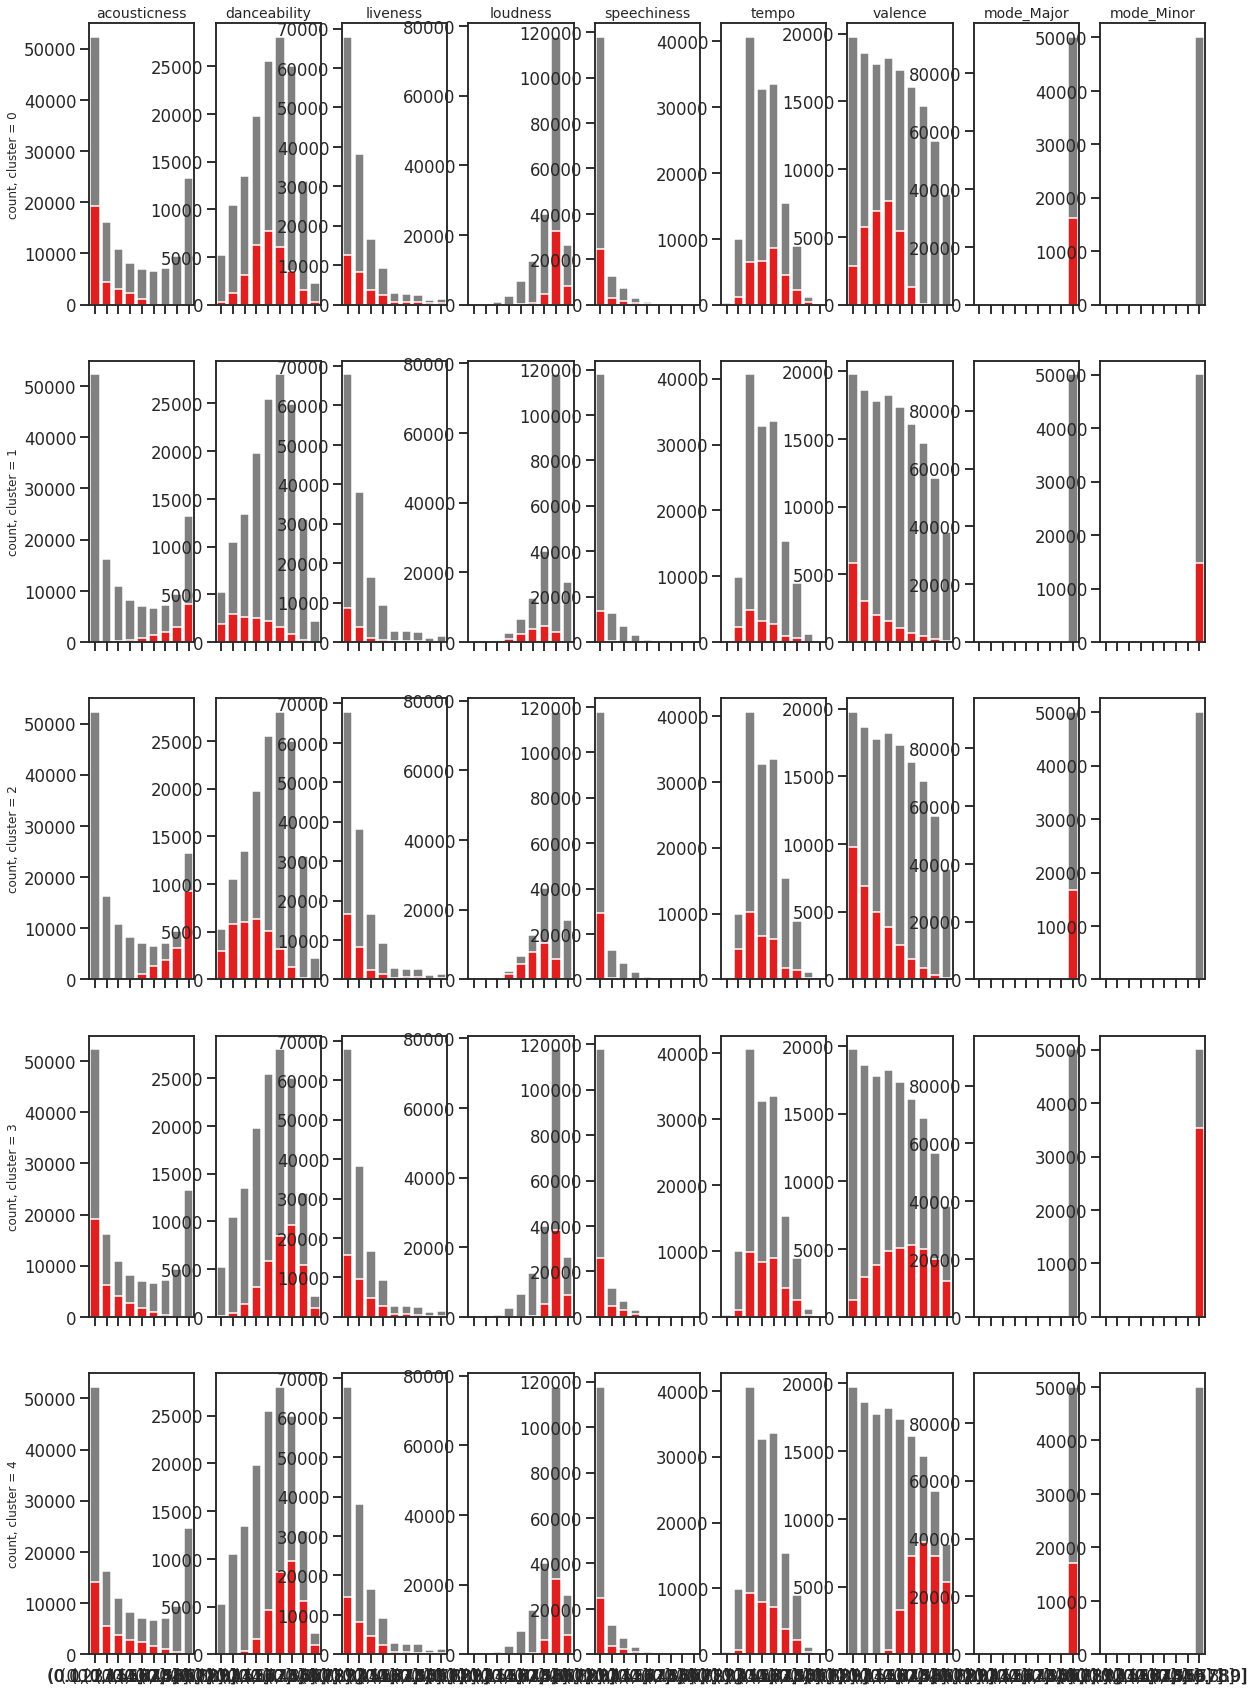

In [ ]:
# set binning intervals 
bins = np.linspace(0,1,10)

# create subplots
num_features = len(X.columns)
f, axes = plt.subplots(k, num_features, 
                       figsize=(20, 30), sharex='col')

# initialise 1st row. Representing cluster
row = 0
for cluster in np.sort(data_clustered['cluster'].unique()):
#     filter cluster dataframe and reset column to 0 for 1st plot for the cluster
    df_cluster = data_clustered[data_clustered['cluster'] == cluster]
    col = 0
    
    for feature in X.columns:
#         create binned count for all recent df and clustered df
        rec_grp = data_clustered.groupby(pd.cut(data_clustered[feature], bins)).size().reset_index(name='count')
        cluster_grp = df_cluster.groupby(pd.cut(df_cluster[feature], bins)).size().reset_index(name='count')
        
#         plot overall distribution and cluster distribution on the ax
        sns.barplot(data=rec_grp, x=feature, y='count', 
                    color='grey', ax=axes[row, col])
        sns.barplot(data=cluster_grp, x=feature, y='count', 
                    color='red', ax=axes[row, col])
        
#         configure ax
        axes[row, col].set_xlabel('')
        if col > 0:
            axes[row, col].set_ylabel('')
        else:
            axes[row, col].set_ylabel(f'count, cluster = {cluster}' , fontsize=12)
        if row == 0:
            axes[row, col].set_title(feature, fontsize=14)        
        col += 1
    row += 1

plt.show()

Culster            | acousticness     |danceablity            | liveness     |loudness            | speechiness     | tempo            | valence| mode     
-------------------|------------------|-------------------|------------------|-------------------|------------------|-------------------|------------------|------------------|
0|Low|Global|Higher|High|Global|Higher|Low|Major
1|High|Low|Global|Low|Global|Global|Global|Minor
2|High|Low|Global|Low|Global|Global|Global|Major
3|Low|High|Global|High|Global|Global|High|Minor
4|Low|High|Global|High|Global|Global|High|Major

* Cluster 0: Major; High loudness, liveness, tempo; Low valence [Fast and Loud]
* Cluster 1: Minor; High acousticness; Low danceablity, loudness[Sad Acoustic]
* Cluster 2: Major; High acousticness; Low danceablity, loudness [Happy Acoustic]
* Cluster 3: Minor; High danceablity, loudness, valence; Low acousticness[Sad dance]
* Cluster 4: Major; High danceablity, loudness, valence; Low acousticness  [Party Vides]


In [ ]:
cluster = 0
#data_id[data_clustered['cluster'] == cluster].sort_values(by=['popularity'], ascending=False).head(10)
data_id[data_clustered['cluster'] == cluster].sample(n=10)

,artist_name,track_name,track_id,mode,genre,popularity
96899,Henry Jackman,The Streets of San Fransokyo,4u79KCwXmB4jnyzNNgVKWV,Major,Soundtrack,25.0
112178,Sara Evans,Infinite Love,5gHyfU1kKbVSUXy8kMpmdv,Major,Country,46.0
144564,Leftöver Crack,Burn Them Prisons,7KDs8iYXTOL4ssUjw8rjIw,Major,Ska,31.0
106423,Bad Brains,Soul Craft,5O5nBXtd7KtKYDwh8MTqYT,Major,Ska,29.0
90146,Kollektiv Turmstrasse,Sorry I Am Late - The Blaze Remix,4YxQ9MCaRTXgfLnz1pXNTP,Major,Electronic,46.0
144288,Kenny Chesney,Big Star - Live,7JKwboSAWRHJI5U1XGTqS3,Major,Country,38.0
150429,Maren Morris,Second Wind (Live from SXSW 2016),7pTkzv1Njtoha6gYDwYmnc,Major,Country,36.0
77178,Aleherion,Ashanti,3u2Vp4XlMzq8DxN3fFaImD,Major,Electronic,29.0
51392,Dean Brody,Bush Party,2biTgRFnGR5U3bP83YZqTa,Major,Country,37.0
91801,Alvvays,Forget About Life,4eKo4tRNkK9WQXjrlP07eU,Major,Folk,51.0


In [ ]:
cluster = 1
#data_id[data_clustered['cluster'] == cluster].sort_values(by=['popularity'], ascending=False).head(10)
data_id[data_clustered['cluster'] == cluster].sample(n=10)

,artist_name,track_name,track_id,mode,genre,popularity
77587,DeJ Loaf,No Better Love,3vJ5g6oVQSYoIiEeQLgXZ0,Minor,R&B,44.0
73134,Joe Lovano,Stella By Starlight,3hY3MPL9hAITPgVfiVlL5K,Minor,Jazz,53.0
10034,Alan Menken,Beast,0VU6iJKM6Tsmt7y8kvAi7D,Minor,Movie,3.0
72354,Thomas Newman,VFD,3f7fCHryW7N3CmFGkaPanL,Minor,Soundtrack,28.0
132912,Paul Desmond,Emily,6joG9hvPqUH0Bm4Zff7Nru,Minor,Jazz,55.0
122714,Brian Newman,Don't Let Me Be Misunderstood (feat. Lady Gaga),6DO29wBOfESk3C2sScpxZn,Minor,Jazz,46.0
91484,Céline Languedoc,Avan i two ta,4dKQTWBarO8bbDjyjqHHM0,Minor,Movie,0.0
63695,Steve Jablonsky,Bumblebee,3EGzq5oQtJe4MxWv1fD2W0,Minor,Soundtrack,46.0
134523,Kyle Dixon & Michael Stein,After Sarah,6ou3hNS6kJiudetwdotPXG,Minor,Soundtrack,38.0
94401,Ghostly Kisses,The City Holds My Heart,4mK7tBW2J8ECW4wvMdpsu3,Minor,Soul,51.0


In [ ]:
cluster = 2
#data_id[data_clustered['cluster'] == cluster].sort_values(by=['popularity'], ascending=False).head(10)
data_id[data_clustered['cluster'] == cluster].sample(n=10)

,artist_name,track_name,track_id,mode,genre,popularity
67216,Trent Reznor and Atticus Ross,Pieces Form the Whole,3PK7tZzJxuoJYoik7j3p1H,Major,Soundtrack,41.0
21210,Kyle Park,Don't Forget Where You Come From,15EJEiqpaFgDISecfkyxH1,Major,Country,42.0
27928,Giuseppe Verdi,"Verdi : La battaglia di Legnano : Act 3 ""Giuri...",1Q9Kv6jR1mkzvIAeEFeQ0v,Major,Opera,12.0
32087,Willie Nelson,Buddy,1dbQNSAXlOEtngcIZAOfPO,Major,Country,53.0
74706,Loco,It Takes Time,3mNbGPCLCxia3yvwWp2P51,Major,R&B,54.0
149852,Elevation Worship,Fullness (Acoustic),7nedtWqbcnE4ZIHj05MHrk,Major,World,48.0
101730,Jeff Buckley,Satisfied Mind,59J9tAbY39foKp478aUsWX,Major,Folk,49.0
27836,Ludwig Goransson,It's Your Time,1Ps1H1hS80nWmx1U5jvhH4,Major,Soundtrack,48.0
19607,Keaton Henson,Alright,100u5LPrxhUb8ACR2LfWAx,Major,Folk,44.0
100757,Sarah Schachner,Ptolemy’s Lament,56Gb0EnhZ6tks2tSVlGKij,Major,Soundtrack,30.0


In [ ]:
cluster = 3
#data_id[data_clustered['cluster'] == cluster].sort_values(by=['popularity'], ascending=False).head(10)
data_id[data_clustered['cluster'] == cluster].sample(n=10)

,artist_name,track_name,track_id,mode,genre,popularity
55198,Nina Sky,Move Ya Body,2ndnVdR8si7CW9T8vJRHyW,Minor,Pop,66.0
114329,Keith Sweat,I'm Not Ready,5n68p2dbjYnXNP9A2nLzbj,Minor,Soul,38.0
106687,Alan Menken,Prolog,5OtprdxjWKed3gYkDwym1S,Minor,Movie,3.0
65260,Europe,Rock the Night,3J9NEWkd9Cx1MwSSvDySkL,Minor,Rock,60.0
19937,Lady Gaga,Bloody Mary,11BKm0j4eYoCPPpCONAVwA,Minor,Dance,47.0
117250,Nina Simone,Funkier Than a Mosquito's Tweeter - Remastered,5wBi26umb4oxXLmpJ32BWV,Minor,Jazz,45.0
13478,Tropidelic,If I Die Tomorrow (Derlee Remix),0gLFHJ7lUaWOGIzigptBOX,Minor,Reggae,18.0
300,Blueface,Bleed the Chicken,00v0g5HQtJSreCdFRmf6zD,Minor,Rap,56.0
105427,FRND,Substitute,5KyXztmJrzUwccF59xw1os,Minor,Indie,45.0
130853,The Suicide Machines,Beat My Head Against The Wall,6dN0kzeG0znRVqcgSfl4wA,Minor,Ska,20.0


In [ ]:
cluster = 4
#data_id[data_clustered['cluster'] == cluster].sort_values(by=['popularity'], ascending=False).head(10)
data_id[data_clustered['cluster'] == cluster].sample(n=10)

,artist_name,track_name,track_id,mode,genre,popularity
38533,Don Omar,Pobre Diabla,1xbw6jObdWhPSoN9MflOSA,Major,Pop,59.000000
124884,10cc,The Things We Do For Love,6KEWtSOGKpIXGw6l1uJgsR,Major,Dance,65.000000
46240,Pablo Cruise,Love Will Find A Way,2LqzuRukwnpeWYLXBtiwmq,Major,Folk,49.666667
113289,Mario Hart,Llego la Hora,5joUD0eK47gHPCd0jfIFua,Major,Reggaeton,35.000000
4426,Natural Vibrations,One On One,0Du5OWHGLgjTpWLvMA1Lz4,Major,Reggae,29.000000
121192,Plan B,La Danza Bella,68WGyc8Am3SpUOo9dMjRAY,Major,Reggaeton,42.000000
73493,Alan Jackson,Jingle Bells,3idyQ4U3SSSdRHa1S6GpGg,Major,Country,37.000000
6594,Less Than Jake,The Rest of My Life,0KhMj83N700Wrofm3hgyiN,Major,Ska,43.000000
53215,Jackie Mittoo,Killer Diller,2hUuLfZEqlAGqlp5aWmcaU,Major,Ska,24.000000
140924,The Essentialists,Magnolia,78lFgN1JjH5bUfIbNgJ5O1,Major,Indie,44.000000


# GMM

In [ ]:
X = data._get_numeric_data().drop(["popularity"], axis=1)
X

,acousticness,danceability,liveness,loudness,speechiness,tempo,valence,mode_Major,mode_Minor
0,0.249999,0.495753,0.326487,0.855057,0.019622,0.232707,0.841,1,0
1,0.367469,0.617245,0.100300,0.852689,0.007531,0.429591,0.307,1,0
2,0.818273,0.764541,0.104339,0.724862,0.055685,0.219846,0.560,0,1
3,0.131525,0.743038,0.076268,0.859110,0.044760,0.432446,0.524,1,0
5,0.069979,0.238792,0.088587,0.796473,0.007425,0.478582,0.110,1,0
...,...,...,...,...,...,...,...,...,...
153680,0.836345,0.318353,0.101310,0.818345,0.004773,0.680115,0.287,0,1
153681,0.401606,0.853779,0.114437,0.884793,0.009228,0.389623,0.889,0,1
153682,0.976908,0.517256,0.352741,0.642944,0.036805,0.502513,0.110,1,0
153683,0.113453,0.708633,0.142710,0.861256,0.119644,0.504562,0.544,0,1


In [ ]:
# Try k = 1 to 10, this takes about 2 mins to run 
ss_dist = []
K = range(2, 20)
for k in K:
    gmm = GaussianMixture(n_components=k, random_state=0)
    gmm = gmm.fit(X)
    ss_dist.append(gmm.bic(X))

8


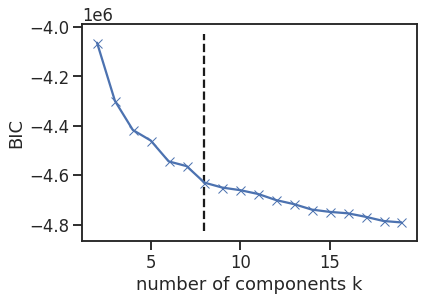

In [ ]:
kn = KneeLocator(K, ss_dist, curve='convex', direction='decreasing')
print(kn.knee)

plt.xlabel('number of components k')
plt.ylabel('BIC')
plt.plot(K, ss_dist, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

In [ ]:
# Final model
k = 8
X = data._get_numeric_data().drop(["popularity"], axis=1)
gmm = GaussianMixture(n_components=k, random_state=0).fit(X)
X

,acousticness,danceability,liveness,loudness,speechiness,tempo,valence,mode_Major,mode_Minor
0,0.249999,0.495753,0.326487,0.855057,0.019622,0.232707,0.841,1,0
1,0.367469,0.617245,0.100300,0.852689,0.007531,0.429591,0.307,1,0
2,0.818273,0.764541,0.104339,0.724862,0.055685,0.219846,0.560,0,1
3,0.131525,0.743038,0.076268,0.859110,0.044760,0.432446,0.524,1,0
5,0.069979,0.238792,0.088587,0.796473,0.007425,0.478582,0.110,1,0
...,...,...,...,...,...,...,...,...,...
153680,0.836345,0.318353,0.101310,0.818345,0.004773,0.680115,0.287,0,1
153681,0.401606,0.853779,0.114437,0.884793,0.009228,0.389623,0.889,0,1
153682,0.976908,0.517256,0.352741,0.642944,0.036805,0.502513,0.110,1,0
153683,0.113453,0.708633,0.142710,0.861256,0.119644,0.504562,0.544,0,1


In [ ]:
data_clustered = X.copy()
data_clustered["cluster"] = gmm.predict(data_clustered)
data_clustered

,acousticness,danceability,liveness,loudness,speechiness,tempo,valence,mode_Major,mode_Minor,cluster
0,0.249999,0.495753,0.326487,0.855057,0.019622,0.232707,0.841,1,0,4
1,0.367469,0.617245,0.100300,0.852689,0.007531,0.429591,0.307,1,0,2
2,0.818273,0.764541,0.104339,0.724862,0.055685,0.219846,0.560,0,1,5
3,0.131525,0.743038,0.076268,0.859110,0.044760,0.432446,0.524,1,0,4
5,0.069979,0.238792,0.088587,0.796473,0.007425,0.478582,0.110,1,0,2
...,...,...,...,...,...,...,...,...,...,...
153680,0.836345,0.318353,0.101310,0.818345,0.004773,0.680115,0.287,0,1,3
153681,0.401606,0.853779,0.114437,0.884793,0.009228,0.389623,0.889,0,1,3
153682,0.976908,0.517256,0.352741,0.642944,0.036805,0.502513,0.110,1,0,4
153683,0.113453,0.708633,0.142710,0.861256,0.119644,0.504562,0.544,0,1,1


In [ ]:
data_clustered.groupby('cluster').size().reset_index(name='Num of songs')

,cluster,Num of songs
0,0,14649
1,1,15568
2,2,22366
3,3,17232
4,4,19987
5,5,17289
6,6,17613
7,7,17979


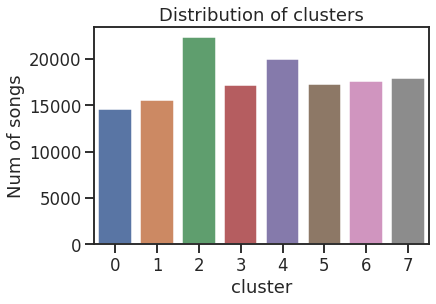

In [ ]:
cluster_size = data_clustered.groupby('cluster').size().reset_index(name='Num of songs')
sns.barplot(data=cluster_size, x='cluster', y='Num of songs',)
plt.title('Distribution of clusters')
plt.show()

In [ ]:
cluster = 0
data_id[data_clustered['cluster'] == cluster].sort_values(by=['popularity'], ascending=False).head(10)

,artist_name,track_name,track_id,mode,genre,popularity
68710,John Legend,All of Me,3U4isOIWM3VvDubwSI3y7a,Major,Soul,85.0
42897,Calum Scott,Dancing On My Own,2BOqDYLOJBiMOXShCV1neZ,Major,Pop,83.0
1523,Billie Eilish,Bored,04sN26COy28wTXYj3dMoiZ,Major,Pop,80.0
89192,Ed Sheeran,Supermarket Flowers,4VuS959DSpr82t3qBqCrWG,Major,Pop,80.0
140826,Rihanna,FourFiveSeconds,78TTtXnFQPzwqlbtbwqN0y,Major,Pop,80.0
128517,A Great Big World,Say Something,6Vc5wAMmXdKIAM7WUoEb7N,Major,Pop,80.0
87688,Plain White T's,Hey There Delilah,4RCWB3V8V0dignt99LZ8vH,Major,Pop,80.0
51162,Aitana,Vas A Quedarte,2b3JxLi8KAiOsD8ehnOxDZ,Major,Pop,79.0
93841,Adele,Someone Like You,4kflIGfjdZJW4ot2ioixTB,Major,Pop,79.0
141295,Kacey Musgraves,Rainbow,79qxwHypONUt3AFq0WPpT9,Major,Country,78.0


In [ ]:
pca = PCA(random_state=123)
pca_results = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
pca.explained_variance_ratio_.cumsum()

[5.83804355e-01 2.29641272e-01 7.73456154e-02 3.78138646e-02
 2.89622463e-02 2.36349453e-02 1.14239138e-02 7.37378851e-03
 3.32229965e-32]


array([0.58380435, 0.81344563, 0.89079124, 0.92860511, 0.95756735,
       0.9812023 , 0.99262621, 1.        , 1.        ])

In [ ]:
df_pca = pd.DataFrame(pca_results, index=X.index)
df_pca['cluster'] = data_clustered["cluster"]
df_pca = pd.concat([df_pca, data_id],axis=1)
df_pca

,0,1,2,3,4,5,6,7,8,cluster,artist_name,track_name,track_id,mode,genre,popularity
0,-0.483609,-0.302825,0.213048,0.170066,-0.020389,-0.289018,-0.017956,-0.036500,-7.939604e-16,4,Henri Salvador,Coeur Brisé à Prendre - Remastered,000CzNKC8PEt1yC3L8dqwV,Major,Movie,5.0
1,-0.493076,-0.029357,-0.076571,-0.134806,-0.067295,0.092517,-0.081956,-0.051509,-2.264597e-15,2,Mike Love,Earthlings,000DfZJww8KiixTKuk9usJ,Major,Reggae,30.0
2,0.905063,0.300137,0.430593,-0.112483,-0.208066,0.004283,-0.046951,-0.010332,3.601485e-17,5,Don Philippe,Fewerdolr,000EWWBkYaREzsBplYjUag,Minor,Jazz,39.0
3,-0.472982,-0.355826,0.004389,-0.162879,-0.062007,0.053189,-0.046149,0.006888,-4.044264e-16,4,ZAYN,Still Got Time,000xQL6tZNLJzIrtIgxqSl,Major,Dance,70.0
5,-0.495741,-0.042128,-0.523528,-0.090894,0.132710,-0.066242,-0.001242,-0.000088,-4.583179e-16,2,C3 Music,The Father's Love - Live,001KkOBeRiQ1J7IEJYHODW,Major,World,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153680,0.884143,0.522860,0.048893,0.001657,0.283064,0.183364,-0.069440,-0.131068,-8.550299e-17,3,Hillsong Worship,Emmanuel,7zz3cHALU9cj7Io5qINt1R,Minor,World,21.0
153681,0.934778,-0.253200,0.465513,-0.073776,-0.028748,-0.008104,-0.104839,-0.042522,-4.964250e-17,3,Caravan Palace,Maniac,7zz7MbCb9G7KJc1NVl9bL0,Minor,Jazz,38.0
153682,-0.532339,0.602392,0.065728,0.129849,-0.105630,0.277258,-0.079256,0.035493,-2.873562e-17,4,Thelonious Monk Quartet,Crepescule With Nellie - Live At Carnegie Hall...,7zzFNNxVD0h0ctAT08H0pa,Major,Jazz,40.0
153683,0.938928,-0.295177,-0.005479,-0.060189,0.007217,0.088210,0.011214,0.002697,-3.809886e-17,1,Magnate Y Valentino,Una En Un Millón,7zzTeItz93lYI52hlcipm5,Minor,Reggaeton,28.0


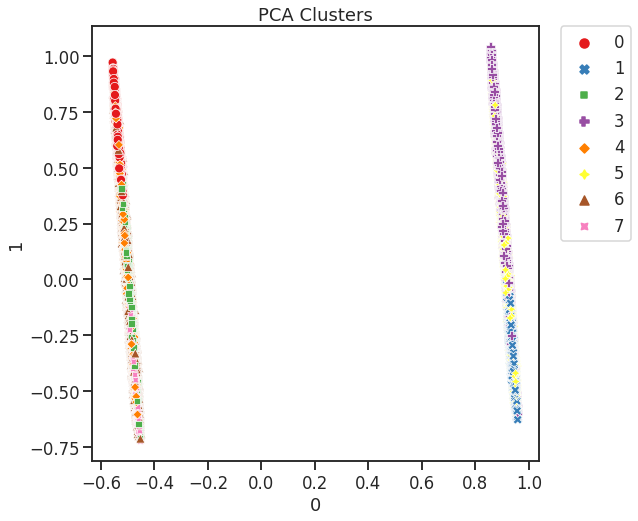

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df_pca, x=0, y=1, hue='cluster', style='cluster', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('PCA Clusters')
plt.show()

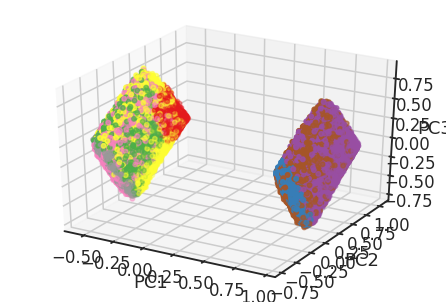

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df_pca[0], df_pca[1], df_pca[2],
           c=df_pca['cluster'], cmap='Set1')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

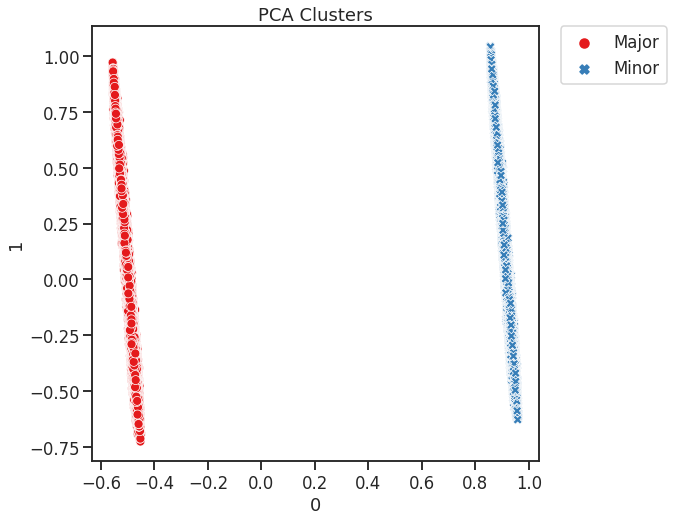

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df_pca, x=0, y=1, hue='mode', style='mode', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('PCA Clusters')
plt.show()

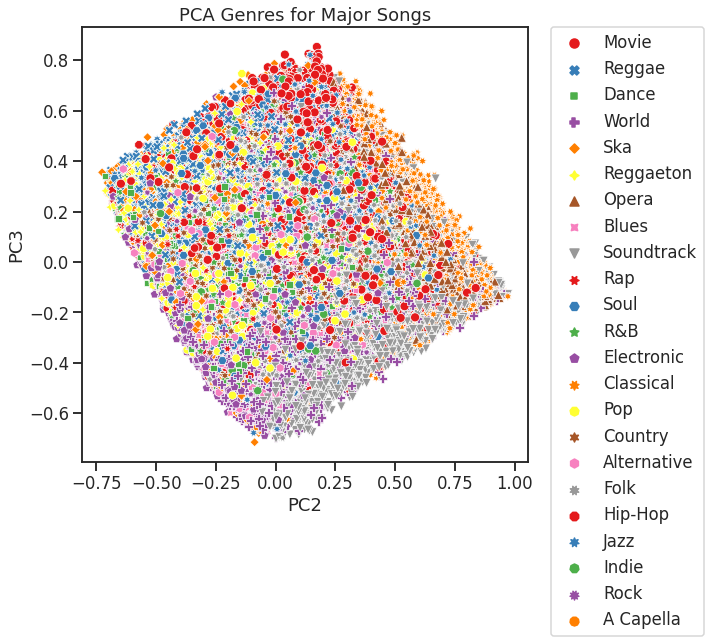

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df_pca[df_pca["mode"]=="Major"], x=1, y=2, hue='genre', style='genre', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('PCA Genres for Major Songs')
ax.set_xlabel('PC2')
ax.set_ylabel('PC3')
plt.show()

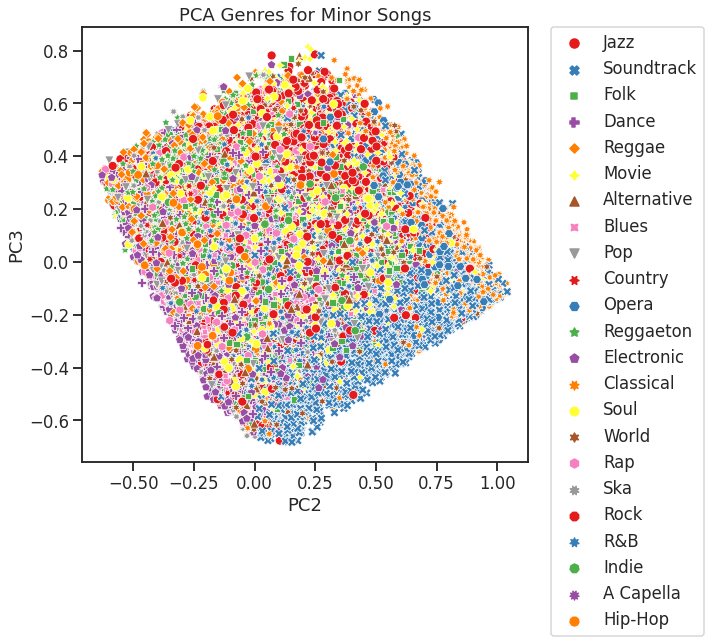

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df_pca[df_pca["mode"]=="Minor"], x=1, y=2, hue='genre', style='genre', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('PCA Genres for Minor Songs')
ax.set_xlabel('PC2')
ax.set_ylabel('PC3')
plt.show()

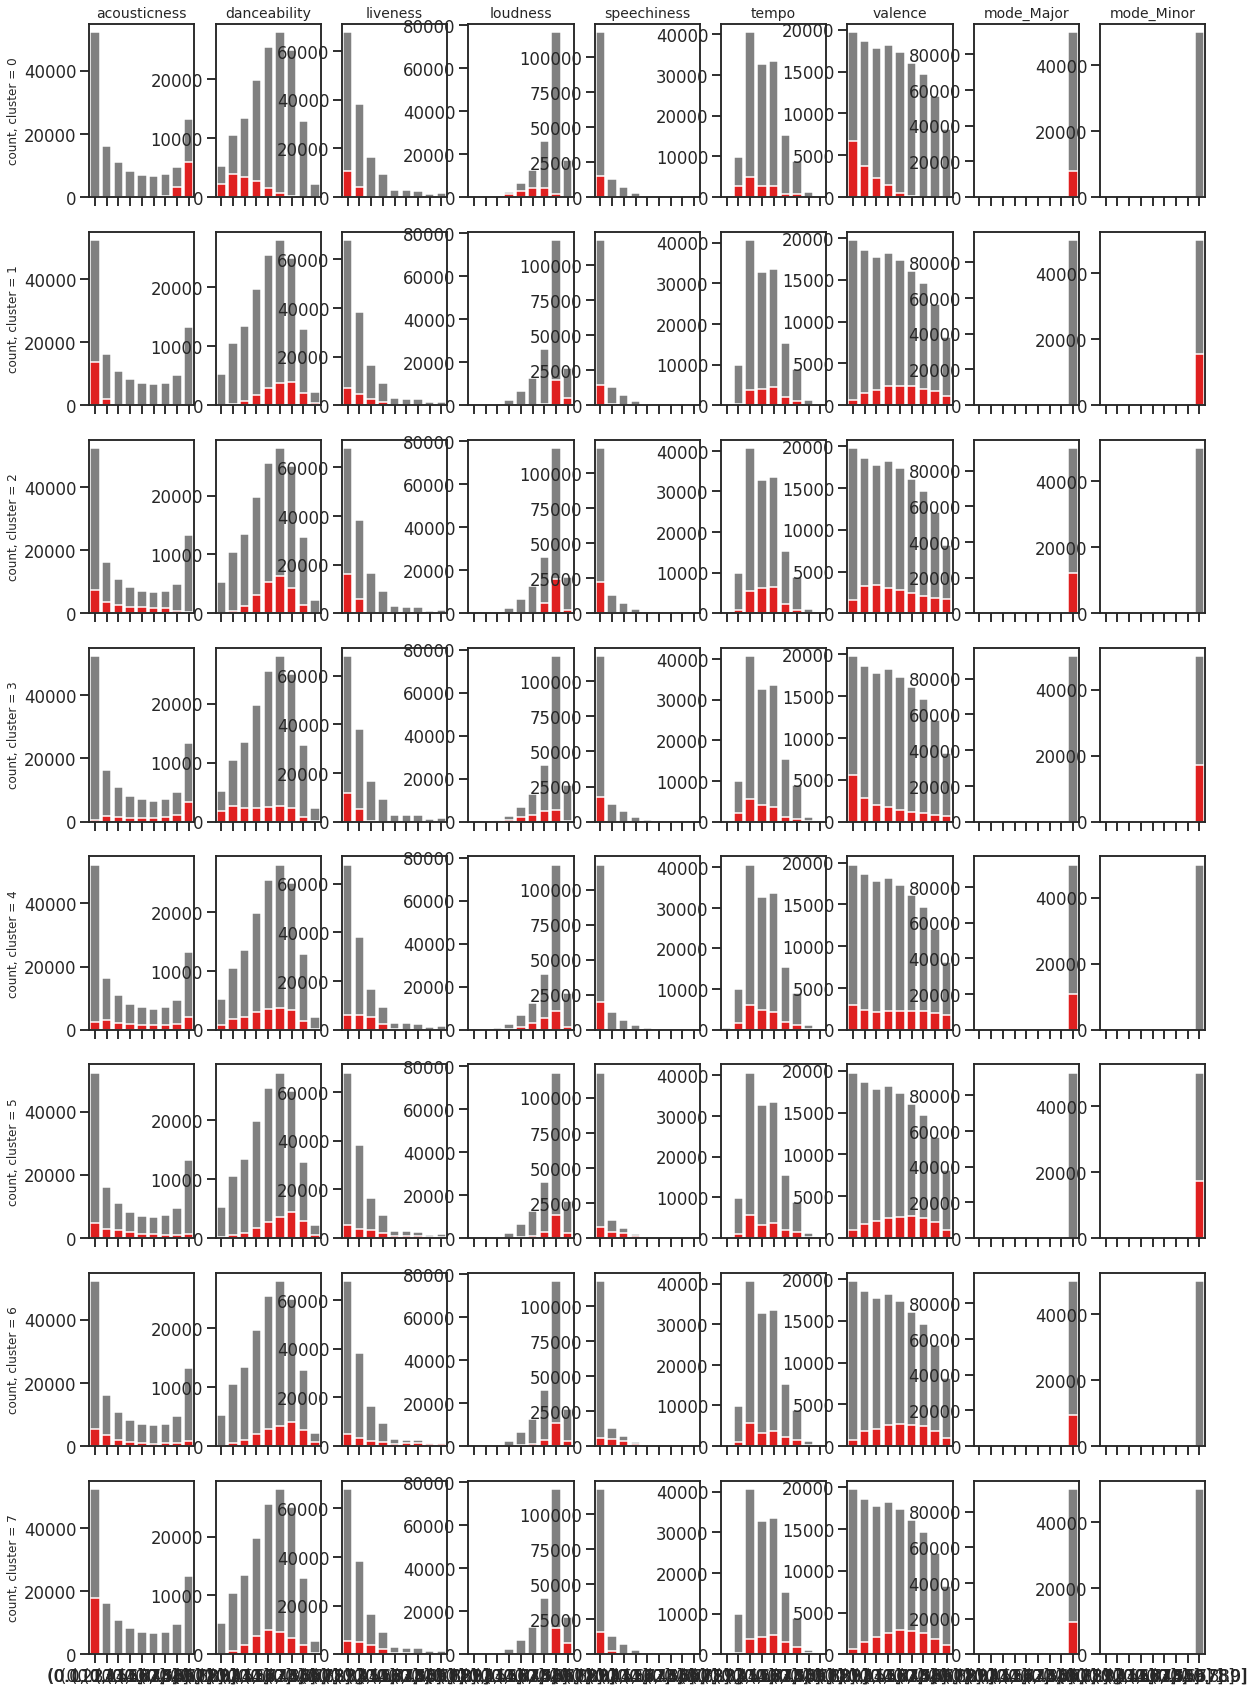

In [ ]:
# set binning intervals 
bins = np.linspace(0,1,10)

# create subplots
num_features = len(X.columns)
f, axes = plt.subplots(k, num_features, 
                       figsize=(20, 30), sharex='col')

# initialise 1st row. Representing cluster
row = 0
for cluster in np.sort(data_clustered['cluster'].unique()):
#     filter cluster dataframe and reset column to 0 for 1st plot for the cluster
    df_cluster = data_clustered[data_clustered['cluster'] == cluster]
    col = 0
    
    for feature in X.columns:
#         create binned count for all recent df and clustered df
        rec_grp = data_clustered.groupby(pd.cut(data_clustered[feature], bins)).size().reset_index(name='count')
        cluster_grp = df_cluster.groupby(pd.cut(df_cluster[feature], bins)).size().reset_index(name='count')
        
#         plot overall distribution and cluster distribution on the ax
        sns.barplot(data=rec_grp, x=feature, y='count', 
                    color='grey', ax=axes[row, col])
        sns.barplot(data=cluster_grp, x=feature, y='count', 
                    color='red', ax=axes[row, col])
        
#         configure ax
        axes[row, col].set_xlabel('')
        if col > 0:
            axes[row, col].set_ylabel('')
        else:
            axes[row, col].set_ylabel(f'count, cluster = {cluster}' , fontsize=12)
        if row == 0:
            axes[row, col].set_title(feature, fontsize=14)        
        col += 1
    row += 1

plt.show()

* Cluster 0: Major; High acounsticness; Low danceablity, liveness, loudness, tempo, Valence
* Cluster 1: Minor; High loudness; Low acounsticness
* Cluster 2: Major; Low acounsticness, liveness
* Cluster 3: Minor; High acounsticness; Low danceablity, loundness, tempo, valence
* Cluster 4: Major; All neutral
* Cluster 5: Minor; High danceablity, speechness
* Cluster 6: Major; High danceablity, liveness, speechness
* Cluster 7: Major; High Loundness, tempo; Low acounsticness, danceablity